# Detekce a přiřazení slov v záznamu řeči

## Import knihoven

In [107]:
import numpy as np
import scipy.io.wavfile
import matplotlib.pyplot as plt
import librosa
import pyttsx3
import sounddevice as sd
import os
from scipy.spatial.distance import directed_hausdorff

## Generování zvukových nahrávek

In [108]:
def create_word_files(word_list, output_dir="wavs"):
    """Generate audio files for given words and return their signals and sampling rates."""
    os.makedirs(output_dir, exist_ok=True)
    engine = pyttsx3.init()
    word_signals = []

    for word in word_list:
        signal_file = os.path.join(output_dir, f"{word}.wav")
        engine.save_to_file(word, signal_file)
        engine.runAndWait()

        try:
            sr, sig = scipy.io.wavfile.read(signal_file)
            word_signals.append([word, sig, sr])
        except Exception as e:
            print(f"Error reading {signal_file}: {e}")

    return word_signals

## Funkce pro zpracování signálu

In [109]:
def trim_speech(signal, trim_threshold=10):
    signal[np.abs(signal) < trim_threshold] = 0
    trimmed_signal = np.trim_zeros(signal)
    start_trimmed = np.count_nonzero(signal[: len(signal) // 2] == 0)
    end_trimmed = np.count_nonzero(signal[len(signal) // 2 :] == 0)
    return trimmed_signal, start_trimmed, end_trimmed


def pad_speech(s1, s2):
    trimmed_s1, _, _ = trim_speech(s1)
    trimmed_s2, _, _ = trim_speech(s2)
    max_size = max(trimmed_s1.size, trimmed_s2.size)
    padded_s1 = np.pad(trimmed_s1, (0, max_size - trimmed_s1.size))
    padded_s2 = np.pad(trimmed_s2, (0, max_size - trimmed_s2.size))
    return padded_s1, padded_s2


def segment_audio(audio_data, segment_size, amplitude_threshold):
    current_pos = 0
    is_speech_detected = False
    silence_counter = 0
    total_length = len(audio_data)

    padded_length = ((total_length // segment_size) + 1) * segment_size
    audio_data = np.pad(audio_data, (0, padded_length - total_length))

    speech_segments = []
    segment_timestamps = []

    for idx, segment in enumerate(
        np.array_split(audio_data, padded_length // segment_size + 1)
    ):
        peak_amplitude = np.max(np.abs(segment))

        if silence_counter > 1 and is_speech_detected:
            trimmed_audio, start_idx, end_idx = trim_speech(
                audio_data[current_pos : (idx + 1) * segment_size]
            )
            speech_segments.append(trimmed_audio)
            segment_timestamps.append(
                (
                    current_pos + start_idx,
                    current_pos + start_idx + len(trimmed_audio),
                )
            )
            current_pos = (idx + 1) * segment_size
            is_speech_detected, silence_counter = False, 0

        elif peak_amplitude >= amplitude_threshold and not is_speech_detected:
            is_speech_detected = True
        elif peak_amplitude < amplitude_threshold and is_speech_detected:
            silence_counter += 1

    if not speech_segments:
        return [audio_data], None
    return speech_segments, segment_timestamps

## Extrakce příznaků 

In [110]:
def extract_features(y, sr, n_fft=2048, n_mfcc=40):
    y = librosa.util.normalize(y.astype(np.float32))
    sY = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft)
    mfccsY = librosa.feature.mfcc(S=librosa.power_to_db(sY), n_mfcc=n_mfcc)
    scY = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft)
    chromaY = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft)

    return mfccsY, scY, chromaY

## Vyhodnocení podobnosti slov se slovy v seznamu a identifikace

In [111]:
def identify_words(audio_name, audio_segments, reference_words):
    print("---------")
    print(f"Odhadnutá věta pro {audio_name}:")
    segment_matches = []

    for segment in audio_segments:
        word_scores = []
        for ref_word, ref_signal, ref_rate in reference_words:
            padded_ref, padded_seg = pad_speech(ref_signal, segment)
            features_ref = extract_features(padded_ref, ref_rate)
            features_seg = extract_features(padded_seg, 22050)

            dist_mfcc = directed_hausdorff(features_ref[0], features_seg[0])[0]
            dist_sc = directed_hausdorff(features_ref[1], features_seg[1])[0]
            dist_chroma = directed_hausdorff(features_ref[2], features_seg[2])[0]

            total_similarity = dist_mfcc + dist_sc * 0.5 + dist_chroma * 0.08
            word_scores.append((ref_word, total_similarity))

        best_match = sorted(word_scores, key=lambda item: item[1])[0][0]
        print(best_match, end=" ")
        segment_matches.append(sorted(word_scores, key=lambda item: item[1])[:4])
    print()
    for matches in segment_matches:
        print(matches)

## Vizualizace rozdělení signálu na jednotlivá slova

In [112]:
def process_and_plot(datapath, segment_size, amplitude_threshold):
    """Load, process, and visualize audio signal from a text file."""
    try:
        data = np.loadtxt(datapath)
    except Exception as e:
        print(f"Error loading {datapath}: {e}")
        return []

    parts, regions = segment_audio(data, segment_size, amplitude_threshold)

    adjusted_data = data * 0.001
    plt.figure(figsize=(10, 5))
    plt.plot(adjusted_data, color="black")

    if regions:
        for start, end in regions:
            plt.axvline(x=start, color="r", linestyle="-", linewidth=1)
            plt.axvline(x=end, color="r", linestyle="-", linewidth=1)
            plt.axvspan(start, end, color="black", alpha=0.5)

    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Signal - {datapath}")
    plt.show()

    return parts

## Spustitelná část

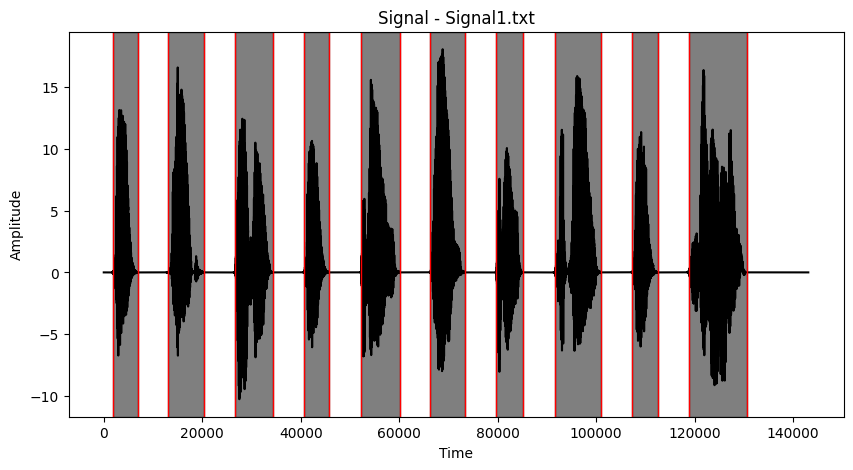

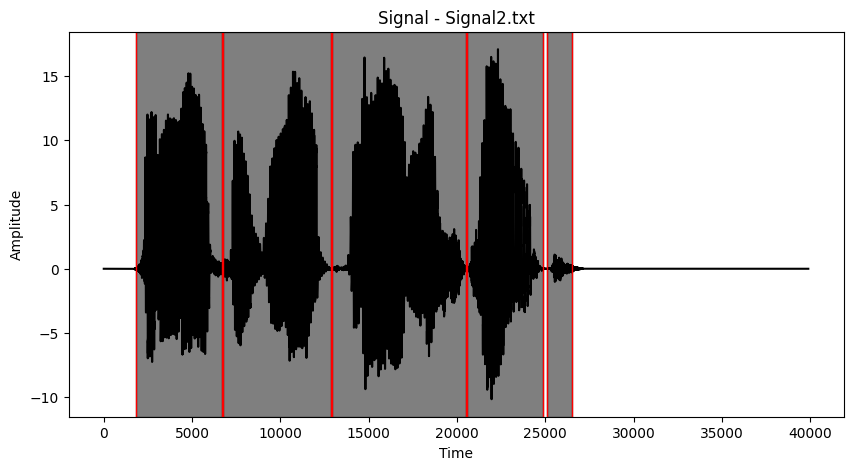

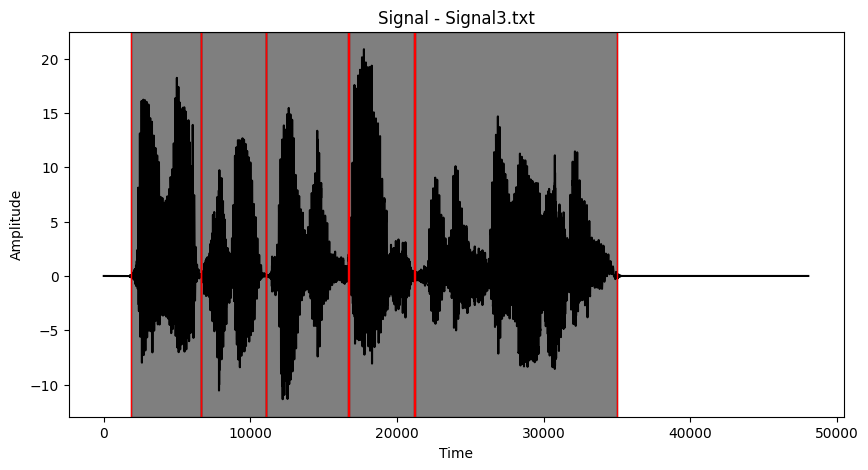

---------
Odhadnutá věta pro Signal1.txt:
the make method the time make for prepare the solution 
[('the', 1875.0970964674343), ('for', 2531.9377553089894), ('give', 2888.8433364436396), ('make', 2899.8159619702906)]
[('make', 1191.6082599937156), ('give', 1792.112085720901), ('work', 2629.775391994521), ('method', 2884.9071663795403)]
[('method', 2332.041342844094), ('lecture', 2440.9347865360583), ('long', 2664.1357842008897), ('fail', 2750.517565979259)]
[('the', 1908.385918787879), ('for', 2585.3437815859047), ('make', 2796.7344376822443), ('no', 2933.2105641865446)]
[('time', 1350.4929103472261), ('for', 2221.563505751911), ('fail', 2599.8906110570147), ('probable', 2981.9201329301272)]
[('make', 2426.9801665948917), ('method', 2438.2309757663347), ('for', 2457.5659653887737), ('long', 2619.124581193154)]
[('for', 2412.408167339559), ('time', 2967.9019076123573), ('give', 3330.1262919395313), ('probable', 3483.1990636647147)]
[('prepare', 2490.24280407102), ('idea', 2712.702776689

In [113]:
word_list = [
    "time",
    "prepare",
    "solution",
    "make",
    "mistake",
    "no",
    "the",
    "probable",
    "long",
    "lecture",
    "method",
    "disaster",
    "fail",
    "work",
    "advice",
    "idea",
    "succeed",
    "easy",
    "is",
    "for",
    "give",
]

word_signals = create_word_files(word_list)

signal_parts = [
    ["Signal1.txt", process_and_plot("Signal1.txt", 600, 1200)],
    ["Signal2.txt", process_and_plot("Signal2.txt", 75, 500)],
    ["Signal3.txt", process_and_plot("Signal3.txt", 75, 800)],
]

for signal_name, parts in signal_parts:
    if parts:
        identify_words(signal_name, parts, word_signals)